This file uses a GMM to generate probability distributions around attributes of our charging data
The model will use 3 GMMs, One for Charging Start time, one for Power, and last for Charging duration.
This completely parametrizes a simple model for EV charging.

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import numpy as np
import random
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import h5py

In [3]:
data_link = ""  # Unfortunately training data is proprietary.
chargeData = np.load(data_link)

In [ ]:
indices = list(range(0, chargeData.shape[0]))

In [ ]:
random.shuffle(indices)

In [ ]:
test_indices = indices[0:2000]

In [23]:
# Get Train and Test Samples used for the GAN for parity
test_data_path = f'{data_link}/data_test.h5'
train_data_path = f'{data_link}/data_train.h5'

with h5py.File(train_data_path, 'r') as hf:
    train_data = hf['data_train'][:]
with h5py.File(test_data_path, 'r') as hf:
    test_data = hf['data_test'][:]

In [24]:
GMM_train_data = train_data

In [25]:
GMM_train_data.shape

(17920, 96)

In [26]:
charging_powers_X = []
charging_powers_Y = []
durations = []
start_times = []  # using the indices as a proxy for this. Simplifies implementation

In [27]:
# Extract Charge Start times and store in a list
num_samples = GMM_train_data.shape[0]
for i in range(num_samples):
    sample_i = GMM_train_data[i]
    charge_indices = np.nonzero(sample_i)[0]
    charge_starttime = charge_indices[0]
    charge_endtime = charge_indices[-1]
    power_value = np.average(sample_i[charge_starttime:charge_endtime+1])
    charging_powers_Y.append([power_value])
    charge_duration = charge_endtime - charge_starttime + 1 # in this case, it is equivalent to number of discrete steps in charging session
    assert charge_duration > 0
    charging_powers_X.append([charge_starttime, charge_duration, power_value])
    durations.append(charge_duration)
    start_times.append(charge_starttime)



In [28]:
for r in durations:
    if r < 0:
        print('error')

In [30]:
start_times = np.reshape(start_times, (num_samples, 1))

In [11]:
charging_powers_X = np.array(charging_powers_X)

In [12]:
charging_powers_X.shape

(17920, 3)

In [ ]:
charging_powers_Y = np.array(charging_powers_Y)
charging_powers_Y.shape

(17920, 1)

In [13]:
durations = np.reshape(durations,  (num_samples, 1))
# durations.shape

In [15]:
gm_powers = GaussianMixture(n_components=125, random_state=0, tol=0.00001, max_iter=50000).fit(charging_powers_X) # Jointly fits time, duration, and power

In [16]:
gm_powers.sample(5)

(array([[5.25031247e+01, 1.20012867e+01, 6.91134923e-01],
        [5.88159465e+01, 1.20004820e+01, 4.06360557e-01],
        [3.09987434e+01, 8.81245643e+00, 3.35170683e-01],
        [7.49369136e+01, 3.00164811e+00, 4.28626657e-01],
        [3.74615238e+01, 3.99893997e+00, 7.04000880e-02]]),
 array([ 46,  46,  97, 100, 124]))

In [17]:
def generateGMM_samples(n_samples, models):
    samples = models.sample(n_samples*2)[0]
    end = samples[:, 0] + samples[:, 1] 
    Samples = np.zeros((n_samples, 96))
    sample_count = 0
    i, j = 0, 0
    while sample_count < n_samples:
        load = np.zeros(96)
        start_i = round(samples[i, 0]) 
        end_i = round(end[i])
        power = samples[i, 2]
        if start_i == end_i or start_i > end_i:
            print('Start > end is not possible')
            i += 1
            continue
        load[start_i:end_i] = power
        Samples[j, :] = load
        sample_count += 1
        j += 1
        i += 1
    return Samples

In [18]:
def plotSamples(samples):
    x = list(range(96))
    n_samples = samples.shape[0]
    for i in range(n_samples):
        plt.plot(np.array(x) * 15/60, samples[i,:])
    plt.xlabel('Hour of the Day')
    plt.ylabel('Power (kW)')
    plt.show() 

In [20]:
# Generate Samples
models = gm_powers
n_samples = 2500
loadSamples = generateGMM_samples(n_samples, models)

Start > end is not possible
Start > end is not possible
Start > end is not possible
Start > end is not possible
Start > end is not possible
Start > end is not possible
Start > end is not possible
Start > end is not possible
Start > end is not possible
Start > end is not possible
Start > end is not possible
Start > end is not possible


In [21]:
time_vec = np.array(list(range(96))) * 15/60

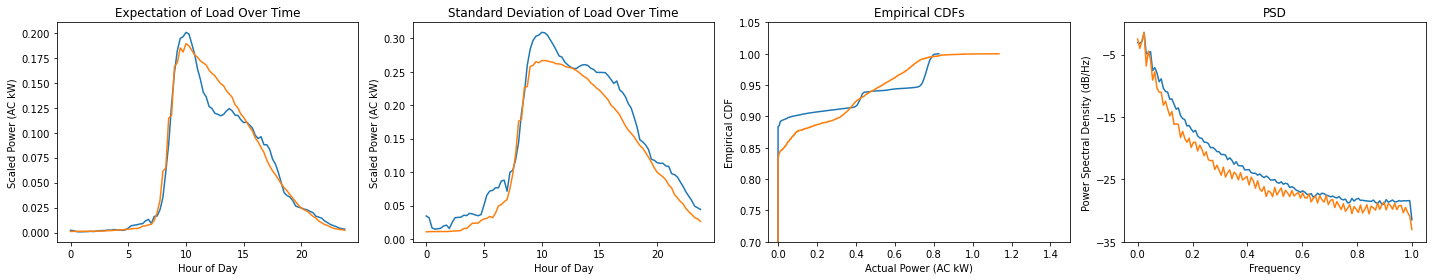

In [22]:
# Plot Results

fig1, (ax1,ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20, 4))  

# Load Expectation Over time
ax1.plot(time_vec, np.average(test_data, axis=0))
ax1.plot(time_vec, np.average(loadSamples, axis=0))
ax1.set_title("Expectation of Load Over Time")
ax1.set_xlabel("Hour of Day")
ax1.set_ylabel("Scaled Power (AC kW)")

# Std
ax2.plot(time_vec, np.std(test_data, axis=0), label="Real (test set)")
ax2.plot(time_vec, np.std(loadSamples, axis=0), label="Generated")
# ax2.legend()
ax2.set_title("Standard Deviation of Load Over Time")
ax2.set_xlabel("Hour of Day")
ax2.set_ylabel("Scaled Power (AC kW)")

# Create a ECDF for the real training data
test_data_ = test_data.flatten()
x_real = np.sort(test_data_)
n_real = x_real.shape[0]
y_real = np.arange(1, n_real + 1) / n_real
ax3.plot(x_real, y_real, label="Real (test set)")
ax3.set_ylim([0.7, 1.05])
ax3.set_xlim([-0.05, 1.5])

# Create a ECDF for the fake generated GMM data
g_fake_data = loadSamples.flatten()
x_fake = np.sort(g_fake_data)
n_fake = x_fake.shape[0]
y_fake = np.arange(1, n_fake + 1) / n_fake
ax3.plot(x_fake, y_fake, label="Generated")
ax3.set_title("Empirical CDFs")
ax3.set_ylabel("Empirical CDF")
ax3.set_xlabel("Actual Power (AC kW)")

# Calculate power spectral density plot
ax4.psd(test_data_, label="Real (test set)")
ax4.psd(g_fake_data, label="Generated")
ax4.set_title("PSD")
ax4.grid(False)

fig1.tight_layout()